# 2023 드라마

In [15]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [16]:
df = pd.read_csv('./data_drama/2023년 방영 드라마.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20231231,2023년 방영 종료 중국 드라마 추천 베스트 5 2023년의 마지막 날입니다. 연...,올해 <b>방영<\/b>이 종료된 <b>드라마<\/b> <b>2023년<\/b> 중...,2023년 방영 종료 중국 드라마 추천 베스트 5
1,20230228,2023년 2월도 다 갔네요. 벌써 3월이라니!!! 한겨울 얼음을 녹이고 봄바람이 ...,오늘은 3월 <b>방영<\/b>예정인 금토일 <b>드라마<\/b>들을 미리보기 해보...,"2023년 3월 금토일 방영예정 한국드라마 - 신성한,이혼 / 판도라: 조작된 낙원..."
2,20221222,법쩐 등장인물 정보_ 2023년 SBS 방영 예정 금토드라마 이선균 문채원 소방서 ...,<b>2023년 방영<\/b>예정<b>드라마<\/b> 법쩐은 김은숙과 함께 <태양의...,법쩐 등장인물 정보_ 2023년 SBS 방영 예정 금토드라마 이선균 문채원 소방서 ...
3,20231120,* OTT 작품 또한 포함하였습니다. 일일드라마는 제외하였습니다. * 편성일정은 변...,영상:http:\/\/youtube.com\/watch?v=PvGctxlzwyM&e...,2023년 12월 방영할 한국 드라마 라인업 모음/정리
4,20240104,1.일타스캔들 사교육 전쟁터에서 펼쳐지는 반찬가게 사장 남행선(전도연)과 대한민국 ...,남은 사람들의 슬픔에 대해 다시 한번 생각하게 만들어주는 드라마 완전 추천한다! #...,[2023년 방영] 드라마_20편 추천| 드라마 리뷰&드라마 추천


## 1. 전처리

In [17]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [18]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = [
'드라마', '2023년', '방영', '예정', '출연', '배우', '이야기', '작품', '원작', '시즌', '방송',
'연출', '줄거리', '부작', '출처', '공개', '사랑', '작가', '사람', '출연진', '장르', '인물',
'추천', '시작', '극본', '시청', '라인업', '사진', '부작', '방송', '공식', '작품',
'배우', '해석', '정보', '상반기', '등장인물', '하반기', '확정', '작가', '순위', '정리', '기대작',
'남자', '여자', '기대', '감독', '사건', '연기', '한국', '제작', '주인공', '대하', '생각', '이미지',
'기준', '소개', '오늘', '캐스팅', '리스트', '종료', '신작', '소식', '고려', '후속'
]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = 'stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [19]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [20]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 19.8 s
Wall time: 1min 30s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20231231,2023년 방영 종료 중국 드라마 추천 베스트 5 2023년의 마지막 날입니다 연말...,올해 b방영b이 종료된 b드라마b b2023년b 중국 b드라마b 순위 5위 장상사 ...,2023년 방영 종료 중국 드라마 추천 베스트 5,중국 베스트 마지막 날 니 연말 정산 포스팅 마지막 넷플릭스 미드 고민 올해 미드 ...,올해 중국 위 장 상사 판타지 선협 고장 극 부 작 플랫폼 국내 캐릭터 로맨스 맛집...,중국 베스트
1,20230228,2023년 2월도 다 갔네요 벌써 3월이라니 한겨울 얼음을 녹이고 봄바람이 불듯 3...,오늘은 3월 b방영b예정인 금토일 b드라마b들을 미리보기 해보도록 하겠습니다 몇몇 ...,2023년 3월 금토일 방영예정 한국드라마 신성한이혼 판도라 조작된 낙원 조선변호사,겨울 얼음 봄 바람 마음 은 금 토 것 데 주말 밤 지 토요일 신성한 이혼 법정 채...,은 금 토 것 데 주말 밤 지,금 토 신성한 이혼 판도라 조작 되 낙원 조선 변호사
2,20221222,법쩐 등장인물 정보 2023년 SBS 방영 예정 금토드라마 이선균 문채원 소방서 옆...,b2023년 방영b예정b드라마b 법쩐은 김은숙과 함께 태양의 후예를 집필한 김원석 ...,법쩐 등장인물 정보 2023년 SBS 방영 예정 금토드라마 이선균 문채원 소방서 옆...,법 금 토 이선균 문채원 소방서 옆 경찰서 법 카르텔 돈 장사 용 법률 기술자 준 ...,법쩐은 김은숙 태양 후예 집필 김원석 영화 악인 전 대외비 이원 태 의기투합 바 의,법 금 토 이선균 문채원 소방서 옆 경찰서
3,20231120,OTT 작품 또한 포함하였습니다 일일드라마는 제외하였습니다 편성일정은 변경될 수 있...,영상httpyoutubecomwatchvPvGctxlzwyMembedsreferri...,2023년 12월 방영할 한국 드라마 라인업 모음정리,포함 일일 제외 편성 일정 변경 수 글 작성 미 표기 부 작 수 확인 불가 시 넷플...,영상 주말 마에스트라 부 작 제공 제공 티빙,모음
4,20240104,1일타스캔들 사교육 전쟁터에서 펼쳐지는 반찬가게 사장 남행선전도연과 대한민국 수학 ...,남은 사람들의 슬픔에 대해 다시 한번 생각하게 만들어주는 드라마 완전 추천한다 드라...,2023년 방영 드라마20편 추천 드라마 리뷰드라마 추천,일타 스캔들 사교육 전쟁터 반찬 가게 사장 남행 선전 대한민국 수학 강사 치열 정경...,슬픔 번 것 주 보,리뷰


In [21]:
# 전처리한 결과 csv로 저장 
df.to_csv('23드라마_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [22]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

### [preprocessed_body]

In [23]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [24]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
3023,로맨스,636
2068,넷플릭스,544
8283,웹툰,452
12108,티빙,348
12182,판타지,297
6269,스릴러,282
4508,범죄,263
9164,인생,262
4709,복수,255
7577,영상,246


### [preprocessed_description]

In [25]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [26]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_description = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_description = all_words_description[all_words_description['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_description.head(30)
top_30_words

,word,count
1498,웨이보,117
2145,텐센트,83
548,로맨스,53
1219,아이치,49
457,도시,33
1897,중국,31
727,바이두,30
355,넷플릭스,28
1982,채널,28
1537,유쿠,26


### [preprocessed_title]

In [27]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [28]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_title = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_title = all_words_title[all_words_title['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_title.head(30)
top_30_words

,word,count
864,중국,138
164,넷플릭스,16
975,티빙,12
260,로맨스,11
963,택시,11
711,웹툰,11
591,악귀,11
309,모범,10
532,스캔들,10
833,조선,10


## 3. 워드 클라우드

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [29]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [30]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'로맨스': 636,
 '넷플릭스': 544,
 '웹툰': 452,
 '티빙': 348,
 '판타지': 297,
 '스릴러': 282,
 '범죄': 263,
 '인생': 262,
 '복수': 255,
 '영상': 246,
 '엄마': 243,
 '채널': 237,
 '조선': 235,
 '택시': 231,
 '가족': 225,
 '악귀': 224,
 '소설': 222,
 '액션': 214,
 '영화': 211,
 '연인': 209,
 '코미디': 209,
 '가지': 207,
 '주연': 205,
 '미스터리': 204,
 '스트리밍': 201,
 '오리지널': 199,
 '시리즈': 198,
 '이후': 196,
 '웨이브': 196,
 '티저': 196,
 '예고': 191,
 '보이': 190,
 '결혼': 189,
 '청춘': 186,
 '비밀': 185,
 '변호사': 185,
 '디즈니': 184,
 '친구': 184,
 '시대': 176,
 '최고': 176,
 '인기': 174,
 '모범': 174,
 '마음': 173,
 '형사': 172,
 '세상': 171,
 '편성': 167,
 '과거': 166,
 '스튜디오': 165,
 '캐릭터': 165,
 '스토리': 163,
 '제목': 163,
 '모습': 162,
 '미정': 161,
 '연애': 161,
 '내용': 160,
 '오후': 160,
 '방송사': 159,
 '제작사': 159,
 '등장': 155,
 '관계': 151,
 '마지막': 140,
 '아이돌': 139,
 '남편': 139,
 '운수': 139,
 '성장': 139,
 '행복': 138,
 '전쟁': 137,
 '배경': 137,
 '이혼': 134,
 '능력': 134,
 '웨이보': 132,
 '기억': 131,
 '닥터': 131,
 '수사': 128,
 '인간': 126,
 '동명': 125,
 '플러스': 125,
 '때문': 124,
 '공조': 124,
 '코믹': 124,
 '출신': 123,
 '

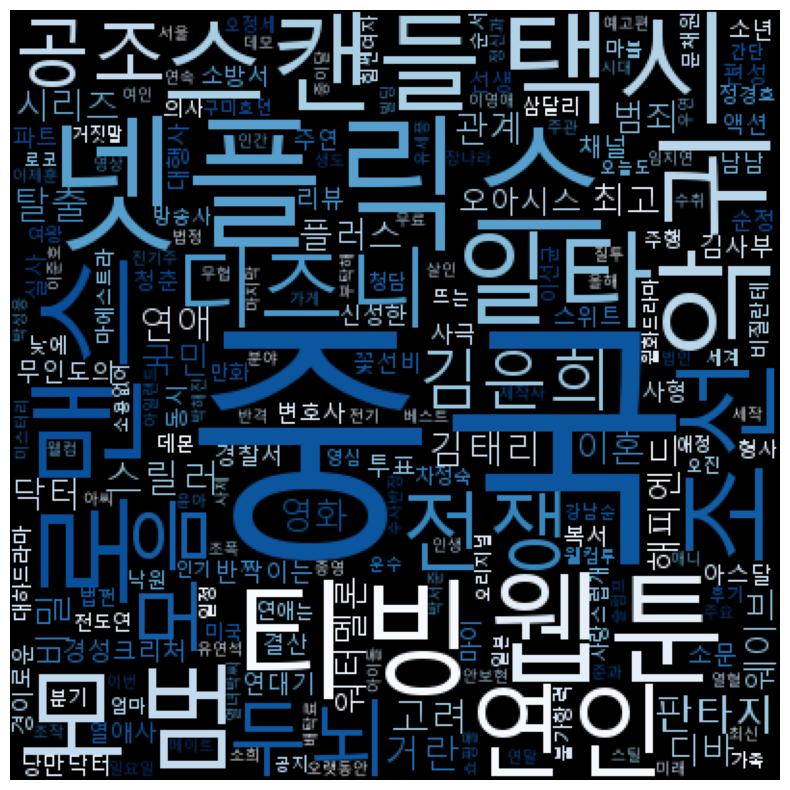

In [39]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBr': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

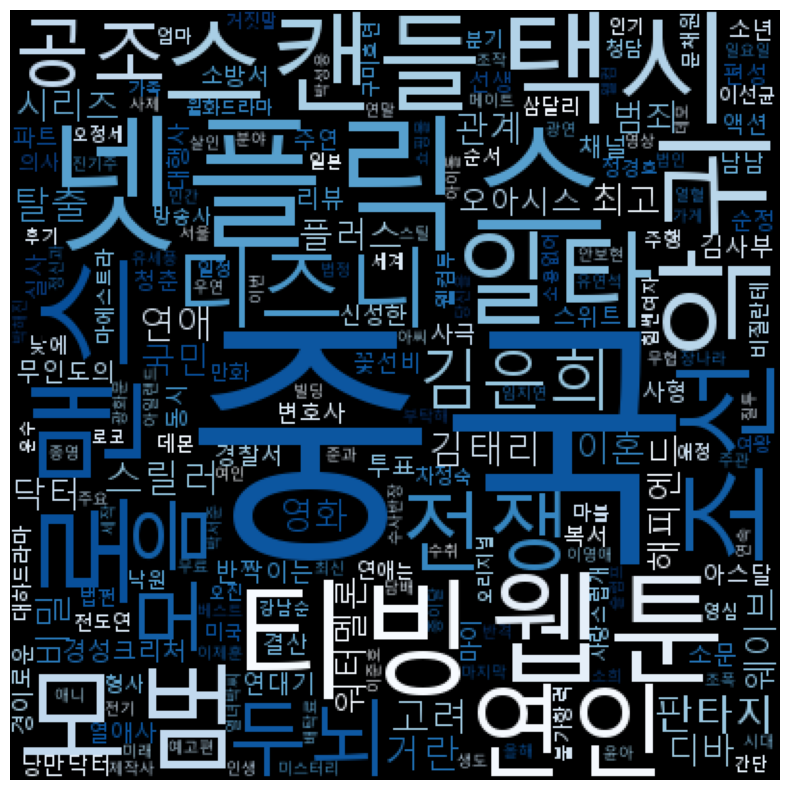

In [44]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'오랫동안', '공지', '뜨는',' 최고', '오늘도'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [description WordCloud]

In [45]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_description.set_index('word').to_dict()['count']
dic_word

{'웨이보': 117,
 '텐센트': 83,
 '로맨스': 53,
 '아이치': 49,
 '도시': 33,
 '중국': 31,
 '바이두': 30,
 '넷플릭스': 28,
 '채널': 28,
 '유쿠': 26,
 '판타지': 25,
 '백과': 23,
 '성장': 21,
 '청춘': 21,
 '범죄': 20,
 '웹툰': 19,
 '인생': 19,
 '미스터리': 17,
 '악귀': 17,
 '올해': 16,
 '가족': 16,
 '모범': 16,
 '티빙': 15,
 '비밀': 15,
 '스릴러': 15,
 '조선': 14,
 '마지막': 14,
 '연인': 14,
 '기간': 13,
 '여성': 13,
 '전쟁': 13,
 '후속작': 13,
 '택시': 13,
 '복수': 12,
 '인기': 12,
 '주말': 12,
 '주연': 12,
 '가지': 12,
 '아이돌': 12,
 '촬영': 12,
 '액션': 11,
 '공조': 11,
 '서울': 11,
 '행복': 11,
 '영상': 11,
 '영화': 11,
 '코미디': 11,
 '마음': 11,
 '사형': 10,
 '웨이브': 10,
 '과거': 10,
 '제공': 10,
 '스캔들': 10,
 '친구': 10,
 '플러스': 10,
 '망고': 10,
 '국민': 10,
 '변호사': 10,
 '시청자': 9,
 '인간': 9,
 '디즈니': 9,
 '투표': 9,
 '방송사': 9,
 '연애': 9,
 '일타': 9,
 '거란': 9,
 '낮에': 9,
 '남녀': 9,
 '힘쎈여자': 9,
 '이혼': 9,
 '결혼': 9,
 '연대기': 9,
 '뜨는': 9,
 '윤아': 8,
 '디바': 8,
 '안녕하세요': 8,
 '두뇌': 8,
 '대한민국': 8,
 '형사': 8,
 '간단': 8,
 '내용': 8,
 '유괴': 8,
 '마에스트라': 8,
 '세상': 8,
 '마이': 8,
 '인용': 8,
 '닥터': 8,
 '저작': 8,
 '로맨틱': 8,
 '해피엔드': 8,
 '살인'

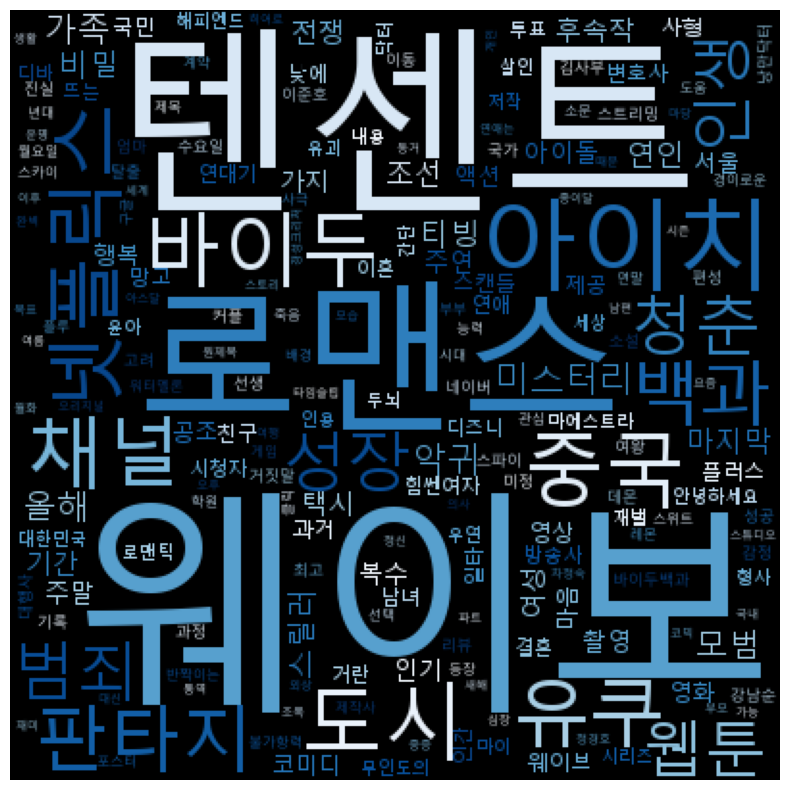

In [46]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

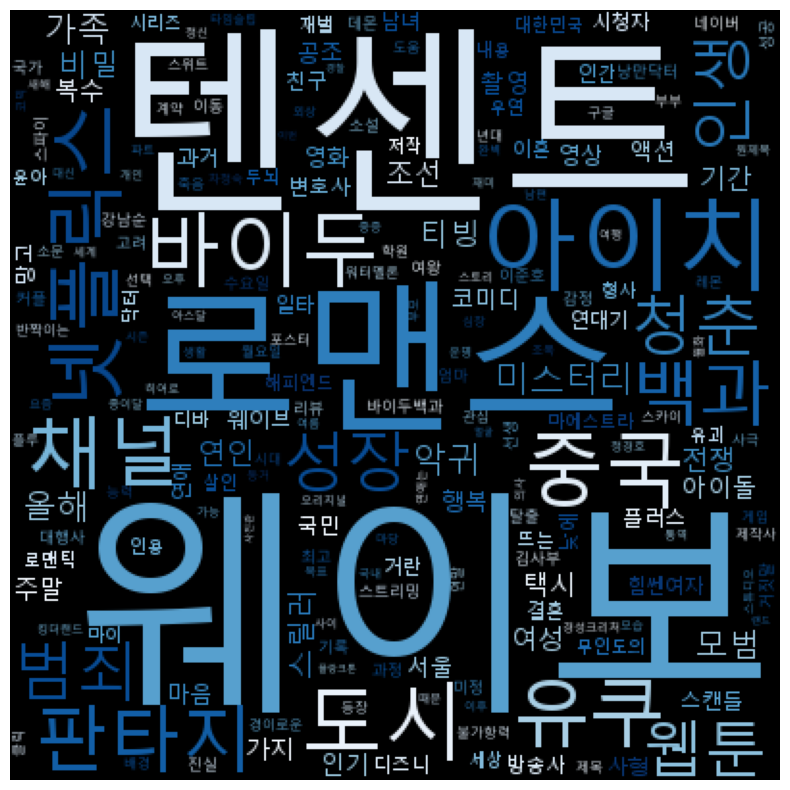

In [47]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'마지막', '안녕하세요', '후속작', '투표', '간단', '제공', '편성', '주연'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [title WordCloud]

In [48]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_title.set_index('word').to_dict()['count']
dic_word

{'중국': 138,
 '넷플릭스': 16,
 '티빙': 12,
 '로맨스': 11,
 '택시': 11,
 '웹툰': 11,
 '악귀': 11,
 '모범': 10,
 '스캔들': 10,
 '조선': 10,
 '연인': 9,
 '일타': 9,
 '디즈니': 8,
 '전쟁': 8,
 '두뇌': 7,
 '모음': 7,
 '공조': 7,
 '김은희': 7,
 '판타지': 7,
 '김태리': 6,
 '고려': 6,
 '스릴러': 6,
 '탈출': 6,
 '비밀': 6,
 '연애': 6,
 '거란': 6,
 '범죄': 5,
 '이혼': 5,
 '웨이브': 5,
 '시리즈': 5,
 '관계': 5,
 '디바': 5,
 '워터멜론': 5,
 '해피엔드': 5,
 '플러스': 5,
 '국민': 5,
 '영화': 5,
 '닥터': 5,
 '최고': 5,
 '오아시스': 5,
 '경성크리처': 5,
 '채널': 5,
 '리뷰': 5,
 '투표': 5,
 '반짝이는': 5,
 '소문': 5,
 '무인도의': 5,
 '김사부': 5,
 '연대기': 5,
 '낭만닥터': 4,
 '순정': 4,
 '청춘': 4,
 '사극': 4,
 '복서': 4,
 '스위트': 4,
 '소년': 4,
 '소방서': 4,
 '파트': 4,
 '변호사': 4,
 '마이': 4,
 '액션': 4,
 '결산': 4,
 '꽃선비': 4,
 '동시': 4,
 '경이로운': 4,
 '경찰서': 4,
 '열애사': 4,
 '주연': 4,
 '아스달': 4,
 '실사': 4,
 '신성한': 4,
 '대행사': 4,
 '편성': 4,
 '남남': 4,
 '선생': 4,
 '사형': 4,
 '낮에': 3,
 '낙원': 3,
 '사랑스럽개': 3,
 '비질란테': 3,
 '삼달리': 3,
 '마에스트라': 3,
 '전도연': 3,
 '방송사': 3,
 '만화': 3,
 '차정숙': 3,
 '문채원': 3,
 '미국': 3,
 '주행': 3,
 '데몬': 3,
 '불가항력': 3,
 '대하드라마': 3,
 '법쩐': 3,
 

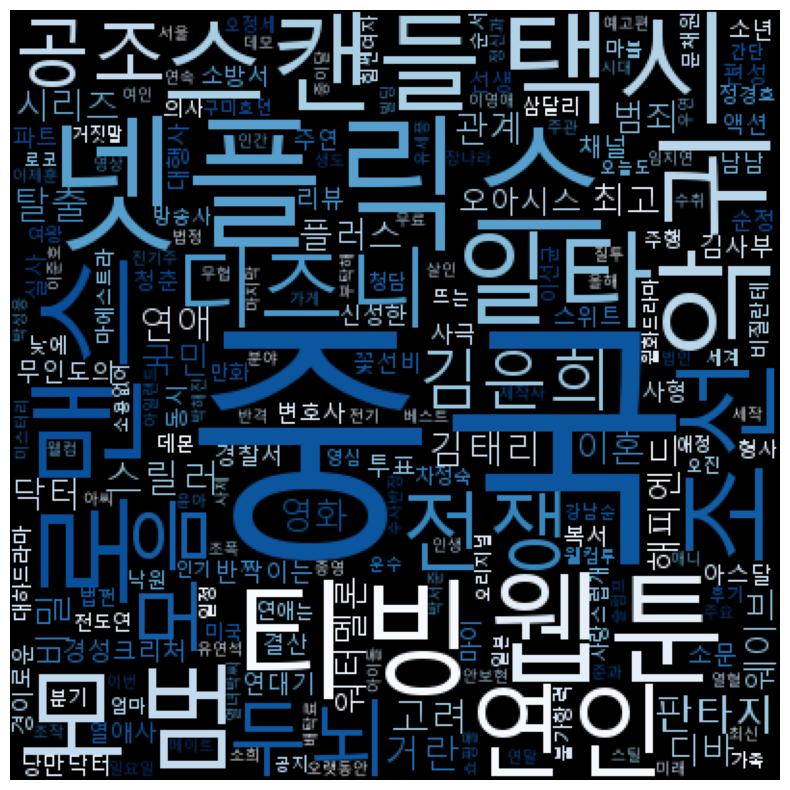

In [49]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

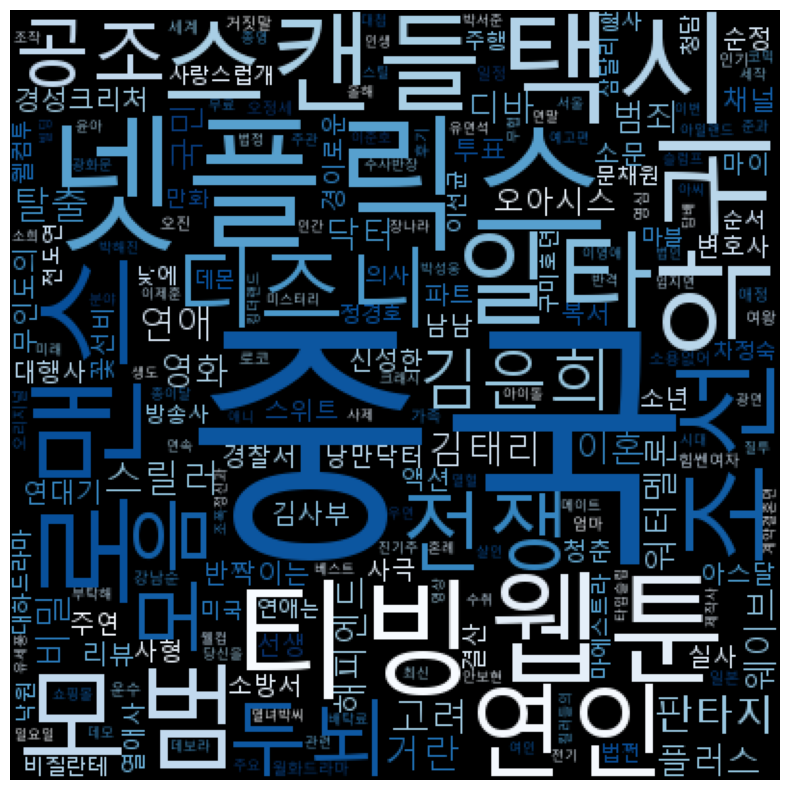

In [50]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'시리즈', '최고', '오늘도', '간단', '편성', '불가항력', '공지', '오랫동안', '분기',
             '마지막', '가게', '뜨는', '동시', '관계'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기